## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ISIR/RedBallGame/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ISIR/RedBallGame


In [ ]:
!pip install seq2pat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ortools-9.14.6206-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (3.3 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-6.31.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
Using cached ortools-9.14.6206-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (27.7 MB)
Using cached absl_py-2.3.1-py3-none-any.whl (135 kB)
Using cached protobuf-6.31.1-cp39-abi3-manylinux2014_x86_64.whl (321 kB)
  Created wheel for seq2pat: filename=seq2pat-2.0.0-cp311-cp311-linux_x86_64.whl size=773027 sha256=c0dd24dd713f5f1c440b2d3aa0a695179f9e3cbd8b8759017276fd28aede4d7b
  Stored in directory: /root/.cache/pip/wheels/c7/ac/57/5d4bb1471310a7c4c219d6cf7eef1af

In [ ]:
import os
import pandas as pd
import string
import re
from enum import Enum
from typing import List
from sequential.seq2pat import Seq2Pat, Attribute
from datetime import timedelta

## Data upload

In [ ]:
#Read the file
def read_file(filename):
    if filename.endswith(".txt"):
        df = pd.read_csv(filename, delimiter='\t', header=None)
        df_filtered = df.iloc[:, [0, 2, 4, 6, 8]]
        df_filtered.columns = ['Tier_Name', 'Start_Time', 'End_Time', 'Duration', 'Annotation_Value']
        return df_filtered

def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

#Clean the data
def clean_data(df):
  # Filter data only to annotations that lie in the game fragments
  scene_records = df[df['Tier_Name'] == 'Scene']

  if not scene_records.empty:
      # Create a list of start and end times for all scene fragments
      scene_intervals = []
      for index, row in scene_records.iterrows():
          scene_intervals.append((row['Start_Time'], row['End_Time']))

      # Filter annotations based on these intervals
      df_filtered = pd.DataFrame()
      for start_time, end_time in scene_intervals:
          df_fragment = df[(df['Start_Time'] >= start_time) & (df['End_Time'] <= end_time)].copy()
          df_filtered = pd.concat([df_filtered, df_fragment])

      df = df_filtered.copy() # Work with the filtered dataframe

  else:
      print("Scene tier not found")

  #Remove NaN value
  df = df.dropna()

  #Remove space
  df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

  #Remove reference numbers in annotations, e.g. "14_mom spits the ball out of the mouth"
  df['Annotation_Value'] = df['Annotation_Value'].apply(lambda x: re.sub(r'^\d+_', '', x) if isinstance(x, str) else x)
  return df

In [ ]:
file_name = "A_12_20130925_1212_01_2.txt"

In [ ]:
df = read_file(file_name)
df = clean_data(df)

In [ ]:
df['Tier_Name'].unique()

array(['Gaze@CHI', 'Facial@MOT', 'Scene', 'Comment', 'Utterance@CHI',
       'Utterance@MOT', 'Prosody@CHI', 'Prosody@MOT', 'Gaze@MOT',
       'Action@CHI', 'Action@MOT', 'Laughter@CHI', 'Laughable@CHI',
       'Laughable@MOT', 'Laughter@MOT', 'Round', 'Arousal@CHI',
       'ReactionReason@CHI'], dtype=object)

In [ ]:
df[df["Tier_Name"] == "Gaze@CHI"]

,Tier_Name,Start_Time,End_Time,Duration,Annotation_Value
0,Gaze@CHI,00:11:08.217,00:11:11.195,00:00:02.978,glass
1,Gaze@CHI,00:11:11.196,00:11:16.011,00:00:04.815,mom's hand
2,Gaze@CHI,00:11:16.011,00:11:20.103,00:00:04.092,mom
3,Gaze@CHI,00:11:20.103,00:11:20.619,00:00:00.516,ball
4,Gaze@CHI,00:11:20.620,00:11:21.371,00:00:00.751,floor
...,...,...,...,...,...
90,Gaze@CHI,00:18:01.510,00:18:02.804,00:00:01.294,floor
91,Gaze@CHI,00:18:02.804,00:18:03.523,00:00:00.719,ball
92,Gaze@CHI,00:18:03.750,00:18:05.159,00:00:01.409,mom's hand
93,Gaze@CHI,00:18:05.250,00:18:09.682,00:00:04.432,mom


## Allen's temporal intervals

In [ ]:
# Allen's temporal intervals
class IntervalRelation(Enum):
    BEFORE = 1
    AFTER = 2
    MEETS = 3
    MET_BY = 4
    OVERLAPS = 5
    OVERLAPPED_BY = 6
    STARTS = 7
    STARTED_BY = 8
    DURING = 9
    CONTAINS = 10
    FINISHES = 11
    FINISHED_BY = 12
    EQUALS = 13

class Interval:
    def __init__(self, name: str, start: float, end: float):
        if start > end:
            raise ValueError("Start time must be less than or equal to end time.")
        self.name = name
        self.start = str(start)
        self.end = str(end)

def interval_relation(interval1: Interval, interval2: Interval) -> IntervalRelation:
    # print(f"interval1: {interval1.name} {type(interval1.start)} {type(interval1.end)}")
    # print(f"interval2: {interval2.name} {type(interval2.start)} {type(interval2.end)}")

    if interval1.end < interval2.start:
        return IntervalRelation.BEFORE
    if interval1.start > interval2.end:
        return IntervalRelation.AFTER

    if interval1.end == interval2.start:
        return IntervalRelation.MEETS
    if interval1.start == interval2.end:
        return IntervalRelation.MET_BY

    if interval1.start < interval2.start < interval1.end < interval2.end:
        return IntervalRelation.OVERLAPS
    if interval2.start < interval1.start < interval2.end < interval1.end:
        return IntervalRelation.OVERLAPPED_BY

    if interval1.start == interval2.start and interval1.end < interval2.end:
        return IntervalRelation.STARTS
    if interval2.start == interval1.start and interval2.end < interval1.end:
        return IntervalRelation.STARTED_BY

    if interval1.start > interval2.start and interval1.end < interval2.end:
        return IntervalRelation.DURING
    if interval2.start > interval1.start and interval2.end < interval1.end:
        return IntervalRelation.CONTAINS

    if interval1.start < interval2.start and interval1.end == interval2.end:
        return IntervalRelation.FINISHES
    if interval2.start < interval1.start and interval2.end == interval1.end:
        return IntervalRelation.FINISHED_BY

    if interval1.start == interval2.start and interval1.end == interval2.end:
        return IntervalRelation.EQUALS
    raise ValueError("Unhandled interval relation.")

def compute_all_relations(intervals: List[Interval]) -> List[List[IntervalRelation]]:
    n = len(intervals)
    relations = [[None for _ in range(n)] for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                relations[i][j] = interval_relation(intervals[i], intervals[j])
    return relations

## Data Counts

In [ ]:
gaze_chi_counts = df[df['Tier_Name']=='Gaze@CHI'].value_counts('Annotation_Value')
gaze_chi_counts

,count
Annotation_Value,
mom,33
ball,30
floor,9
toy,6
toys,6
glass,5
mom's hand,2
ceiling,1
aside,1


In [ ]:
gaze_mot_counts = df[df['Tier_Name']=='Gaze@MOT'].value_counts('Annotation_Value')
gaze_mot_counts

,count
Annotation_Value,
child,44
invisible,29
ball,20
toys,8
into the distance,5
floor,5
glass,3
dad,2
aside,1


In [ ]:
laughter_chi_counts = df[df['Tier_Name']=='Laughter@CHI'].value_counts('Annotation_Value')
laughter_chi_counts

,count
Annotation_Value,
L,46


In [ ]:
laughter_mot_counts = df[df['Tier_Name']=='Laughter@MOT'].value_counts('Annotation_Value')
laughter_mot_counts

,count
Annotation_Value,
L,6
SL,4


In [ ]:
utterance_chi_counts = df[df['Tier_Name']=='Utterance@CHI'].value_counts('Annotation_Value')


In [ ]:
utterance_chi_counts.index.tolist()

['excited breathing',
 'focused breathing',
 'heavy breathing',
 'ah',
 'eh',
 'khem',
 'huh',
 'a-ah',
 'mhm',
 'uh-huh',
 'yah']

In [ ]:
utterance_mot_counts = df[df['Tier_Name']=='Utterance@MOT'].value_counts('Annotation_Value')
utterance_mot_counts.index.tolist()

['Ready?',
 'Drop it.',
 'chooga',
 '... tickle you',
 'Can I please have a ball?',
 'Can you sit up?',
 'I love you.',
 'I take this one.',
 'Drop it in.',
 'I hope this is not the laugh before the cry.',
 'Put it in here.',
 'Keep falling.',
 'She’s laughing so hard that she literally can’t even stay seated.',
 'Really far.',
 'This is harmonious to hear.',
 'Too far.',
 'What even set off you laughing so hard?',
 'Yeaaah!']

In [ ]:
prosody_mot_counts = df[df['Tier_Name']=='Prosody@MOT'].value_counts('Annotation_Value')
prosody_mot_counts

,count
Annotation_Value,
falling,11
rising,5
flat,4
rising-falling,1


In [ ]:
facial_mot_counts = df[df['Tier_Name']=='Facial@MOT'].value_counts('Annotation_Value')
facial_mot_counts

,count
Annotation_Value,
invisible,29
smile showing teeth,21
neutral,17
smile,11
O-shaped mouth,7
widely opened eyes,6
biting lower lip,1


In [ ]:
action_mot_counts = df[df['Tier_Name']=='Action@MOT'].value_counts('Annotation_Value')
action_mot_counts

,count
Annotation_Value,
holding the ball in mouth,17
picking up the ball,15
spitting out the ball,15
putting the ball in mouth,14
tossing the ball,7
moving towards the ball to take it,7
building a toy pyramid,5
taking the ball,3
extending a hand,3


In [ ]:
action_chi_counts = df[df['Tier_Name']=='Action@CHI'].value_counts('Annotation_Value')
# action_chi_counts

In [ ]:
reactionreason_chi_counts = df[df['Tier_Name']=='ReactionReason@CHI'].value_counts('Annotation_Value')
reactionreason_chi_counts

,count
Annotation_Value,
Prank,12
Prediction,10
Violation of social role schema,4
Violation of event schema,4
Violation of behaviour schema,3
Conformity to object schema,2
Violation of object schemas,2
Violation of Facial Schema,2
Conformity to event schema => Not that excited anymore,1


## Data Categorization

In [ ]:
# Utterance categories
utterances_chi = df[df['Tier_Name'] == "Utterance@CHI"]

confirmations = ["uh-huh", "huh", "yah", "mhm"]
vocalizations = ["heavy breathing", "eh"]
interjections = ["focused breathing", "ah", "a-ah", "khem"]
exclamations = ["excited breathing"]

questions = [
    "Ready?",
    "Can I please have a ball?",
    "What even set off you laughing so hard?"
]
commands = [
    "Drop it.",
    "Drop it in.",
    "Put it in here.",
    "Can you sit up?",
]
affection = [
    "I love you."
]

playful_sounds = [
    "chooga",
    "... tickle you",
    "Yeaaah!"
]

statements = [
    "She’s laughing so hard that she literally can’t even stay seated.",
    "I hope this is not the laugh before the cry.",
    "Really far.",
    "Too far.",
    "I take this one.",
    "This is harmonious to hear.",
    "Keep falling."
]


utterances_mot = df[df['Tier_Name'] == "Utterance@MOT"]

utterance_lists = {
    'question': questions,
    'statement': statements,
    'affection': affection,
    'confirmation': confirmations,
    'vocalization': vocalizations,
    'exclamation': exclamations,
    'playful_sounds': playful_sounds
}

utterance_category_mapping = {value: category for category, values in utterance_lists.items() for value in values}
utterance_category_mapping

def get_utterance_category(value):
    return utterance_category_mapping.get(value)

In [ ]:
# after seeing the action this many times, it becomes expected
EXPECTED_THRESHOLD = 2

def categorize_action_mot(action_value, action_history):
    """
    Categorizes a mother's action as expected or unexpected based on history.
    """
    if action_value in action_history and action_history[action_value] >= EXPECTED_THRESHOLD:
        return 'expected'
    else:
        return 'unexpected'

def get_action_mot_category(row, action_history):
    if row['Tier_Name'] == 'Action@MOT':
        action = row['Annotation_Value']
        category = categorize_action_mot(action, action_history)

        if action in action_history:
            action_history[action] += 1
        else:
            action_history[action] = 1
        # print(category, action_history[action])
        return f"{category}"
        # return f"{action} ({category})"
    else:
        return row['Annotation_Value']

In [ ]:
def simplify_gaze_pattern(annotation):
    mapping = {
        "SharedAttention": "ShA",
        "MutualAttention": "MA",
        "SingleAttention(MOT)": "SA(MOT)",
        "SingleAttention(CHI)": "SA(CHI)",
        "LostAttention": "L"
    }
    return mapping.get(annotation, annotation)

In [ ]:
def extract_target(annotation_value):
    if '(' in annotation_value and ')' in annotation_value:
        return annotation_value.split('(')[-1].split(')')[0].strip()
    return annotation_value.strip()


def infer_attention_patterns(sequence_intervals):
    patterns = []

    gaze_chi = sequence_intervals[sequence_intervals['Tier_Name'].str.startswith("Gaze@CHI")].copy()
    gaze_mot = sequence_intervals[sequence_intervals['Tier_Name'].str.startswith("Gaze@MOT")].copy()

    for _, chi_row in gaze_chi.iterrows():
        for _, mot_row in gaze_mot.iterrows():
            start_overlap = max(chi_row['Start_Time'], mot_row['Start_Time'])
            end_overlap = min(chi_row['End_Time'], mot_row['End_Time'])

            if start_overlap < end_overlap:
                chi_target = extract_target(chi_row['Annotation_Value'])
                mot_target = extract_target(mot_row['Annotation_Value'])

                if chi_target == "mom" and mot_target == "child":
                    label = "MA"
                    # label = "MutualAttention"
                elif mot_target == "invisible":
                    label = "?"
                    # label = "Unknown"
                elif chi_target == "mom":
                    label = "SA(CHI)"
                    # label = "SingleAttention(CHI)"
                elif mot_target == "child":
                    label = "SA(MOT)"
                    # label = "SingleAttention(MOT)"
                elif chi_target == mot_target:
                    label = "ShA"
                    # label = "SharedAttention"
                elif chi_target != mot_target:
                    # print(f"start_overlap: {start_overlap}, {type(start_overlap)}, end_overlap: {end_overlap}, {type(end_overlap)}")
                    label = "L"
                    # label = "LostAttention"
                else:
                    label = "?"
                    # label = "Unknown"

                patterns.append({
                    'Tier_Name': 'GazePattern',
                    'Annotation_Value': label,
                    'Start_Time': str(start_overlap),
                    'End_Time': str(end_overlap)
                })

    gaze_patterns_df = pd.DataFrame(patterns)
    # Sort by start time
    gaze_patterns_df = gaze_patterns_df.sort_values(by='Start_Time').reset_index(drop=True)

    # Merge consecutive identical labels
    merged = []
    for i, row in gaze_patterns_df.iterrows():
        if not merged:
            merged.append(row)
        else:
            prev = merged[-1]
            # Merge if label is the same and the time intervals are adjacent
            if prev['Annotation_Value'] == row['Annotation_Value']:
                merged[-1]['End_Time'] = row['End_Time']
            else:
                merged.append(row)

    merged_df = pd.DataFrame(merged)
    return pd.concat([sequence_intervals, merged_df], ignore_index=True)


In [ ]:
threshold = pd.to_timedelta("1s")
threshold

Timedelta('0 days 00:00:01')

In [ ]:
def add_temporal_postfixes_to_actions(sequence_intervals, use_postfixes_only=True):
    """
    Add postfixes -MEETS(...) and -MET_BY(...) to Action@MOT events
    """
    import pandas as pd

    # Work only on Action@MOT
    actions = sequence_intervals[sequence_intervals['Tier_Name'] == 'Action@MOT'].copy()
    actions = actions.sort_values(by='Start_Time').reset_index(drop=True)

    # threshold = pd.to_timedelta("3s")

    new_tier_name="ActionTemporal@MOT"

    updated_rows = []
    enriched_rows = []

    for i, row in actions.iterrows():
        current_start = pd.to_timedelta(row['Start_Time'])
        current_end = pd.to_timedelta(row['End_Time'])
        current_value = row['Annotation_Value']
        postfixes = []

        # Check previous
        if i > 0:
            prev = actions.iloc[i - 1]

            # print(f"prev: {prev['End_Time']}, {type(prev['End_Time'])}")
            # print(f"current_start: {current_start}, {type(current_start)}")

            prev_value = prev['Annotation_Value']
            postfixes.append(f"FOLLOWED_BY({prev_value})")

        # Check next
        if i < len(actions) - 1:
            next_ = actions.iloc[i + 1]
            next_value = next_['Annotation_Value']
            postfixes.append(f"FOLLOWS({next_value})")

        if postfixes:
            enriched_row = row.copy()
            enriched_row['Tier_Name'] = new_tier_name
            enriched_row['Annotation_Value'] = f"{current_value}-{'-'.join(postfixes)}"
            enriched_rows.append(enriched_row)

    # Create DataFrame for new tier
    new_tier_df = pd.DataFrame(enriched_rows)

    # Combine with original data
    combined_df = pd.concat([sequence_intervals, new_tier_df], ignore_index=True)
    return combined_df.sort_values(by='Start_Time').reset_index(drop=True)


## Generate Sequences

In [ ]:
def preprocessing(sequence_intervals, action_history):
  # assigning utterance to categories
  utterance_mask = sequence_intervals['Tier_Name'].str.startswith("Utterance")
  sequence_intervals.loc[utterance_mask, 'Annotation_Value'] = sequence_intervals.loc[utterance_mask, 'Annotation_Value'].apply(get_utterance_category)

  # adding category to mother's actionAC
  # sequence_intervals['Annotation_Value'] = sequence_intervals.apply(lambda row: get_action_mot_category(row, action_history), axis=1)

  # Simplify GazePattern annotations
  # gaze_pattern_mask = sequence_intervals['Tier_Name'] == "GazePattern"
  # sequence_intervals.loc[gaze_pattern_mask, 'Annotation_Value'] = sequence_intervals.loc[gaze_pattern_mask, 'Annotation_Value'].apply(simplify_gaze_pattern)

  sequence_intervals = infer_attention_patterns(sequence_intervals)


  sequence_intervals = add_temporal_postfixes_to_actions(sequence_intervals, use_postfixes_only=True)

  return sequence_intervals

In [ ]:
def generate_sequences_intervals(data_df, tiers_to_exclude=[], include_only_tiers=[]):
    all_tier_names = data_df['Tier_Name'].unique()
    action_history = {}

    # target_tier_intervals_df = data_df[data_df['Tier_Name'] == target_tier_name]
    # target_tier_intervals = target_tier_intervals_df[['Start_Time', 'End_Time']].values.tolist()

    observable_tiers = include_only_tiers if len(include_only_tiers) else [name for name in all_tier_names if name not in tiers_to_exclude]
    observable_events_df = data_df[data_df['Tier_Name'].isin(observable_tiers)].copy()

    overlapping_events_list = []
    all_overlapping_events_df = pd.DataFrame()

    round_tier_intervals_df = data_df[data_df['Tier_Name'] == 'Round']
    round_tier_intervals = round_tier_intervals_df[['Start_Time', 'End_Time']].values.tolist()

    # Iterate through each event in the target tier
    for start_time, end_time in round_tier_intervals:
        # Events that overlap with the target interval
        overlapping_events_for_current_interval = observable_events_df[
            (observable_events_df['Start_Time'] <= end_time) &
            (observable_events_df['End_Time'] >= start_time)
        ].copy()

        all_overlapping_events_df = pd.concat(
            [all_overlapping_events_df, overlapping_events_for_current_interval],
            ignore_index=True
        )

        processed_overlapping_events = preprocessing(overlapping_events_for_current_interval, action_history)
        overlapping_events_list.append(processed_overlapping_events.to_dict('records'))

    return overlapping_events_list, all_overlapping_events_df

In [ ]:
def relations_to_list(intervals: List[Interval], relations: List[List[IntervalRelation]]) -> List[str]:
    result = []
    n = len(intervals)

    for i in range(n):
        for j in range(i + 1, n):
            relation = relations[i][j]
            if relation:  # If there is a relation object (not None or False)
                relation_str = f"{intervals[i].name}-{relation.name}-{intervals[j].name}"
                result.append(relation_str)

    return result

In [ ]:
def generate_relation_sequences(sequences, remove_precise_info=True):
  relation_sequences = []

  for interval_sequence in sequences:
    cleaned_intervals = []

    for interval in interval_sequence:
        tier_name = interval['Tier_Name']
        start_time = interval['Start_Time']
        end_time = interval['End_Time']

        if remove_precise_info:
          label = tier_name
        else:
          annotation = interval['Annotation_Value']
          label = f"{tier_name}({annotation})"

        cleaned_intervals.append(Interval(label, start_time, end_time))

    relations = compute_all_relations(cleaned_intervals)
    relation_sequence = relations_to_list(cleaned_intervals, relations)
    relation_sequences.append(relation_sequence)

  relation_sequences = list(filter(None, relation_sequences))
  return relation_sequences

## Analysis

In [ ]:
def main(file_name, remove_precise_info=True, tiers_to_exclude=[], include_only_tiers=[]):
  df = read_file(file_name)
  df = clean_data(df)
  observable_events_list, all_overlapping_events_df = generate_sequences_intervals(df, tiers_to_exclude, include_only_tiers)
  relation_sequence_intervals = generate_relation_sequences(observable_events_list, remove_precise_info)
  return Seq2Pat(sequences=relation_sequence_intervals)

In [ ]:
seq2pat = main(file_name=file_name, remove_precise_info=False, tiers_to_exclude=["Round", "Scene", "Comment"])

In [ ]:
seq2pat._num_rows

17

In [ ]:
result = seq2pat.get_patterns(min_frequency=3)
# result

In [ ]:
pattern = [
    item for item in result
    if not any(isinstance(subitem, str) and 'GazePattern' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and 'ActionTemporal' in subitem for subitem in item)
    and any(isinstance(subitem, str) and 'Action@MOT(picking up the ball)' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and 'Gaze@MOT(child)' in subitem for subitem in item)
    and any(isinstance(subitem, str) and 'Gaze@CHI(mom)' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and ('Utterance@MOT(question)') in subitem for subitem in item)
]
len(pattern)

25

In [ ]:
pattern

[['Action@MOT(picking up the ball)-BEFORE-Gaze@CHI(mom)',
  'Action@MOT(picking up the ball)-BEFORE-Action@MOT(putting the ball in mouth)',
  4],
 ['Action@MOT(picking up the ball)-BEFORE-Gaze@CHI(mom)',
  'Action@MOT(picking up the ball)-BEFORE-Arousal@CHI(middle)',
  4],
 ['Action@MOT(picking up the ball)-BEFORE-Gaze@CHI(mom)',
  'Action@MOT(picking up the ball)-BEFORE-Laughter@CHI(L)',
  4],
 ['Action@MOT(picking up the ball)-BEFORE-Gaze@MOT(child)',
  'Action@MOT(picking up the ball)-BEFORE-Gaze@CHI(mom)',
  4],
 ['Gaze@CHI(mom)-OVERLAPS-Action@MOT(picking up the ball)',
  'Gaze@CHI(mom)-MEETS-Gaze@CHI(ball)',
  4],
 ['Action@MOT(picking up the ball)-BEFORE-Action@MOT(putting the ball in mouth)',
  'Action@MOT(picking up the ball)-BEFORE-Gaze@CHI(mom)',
  3],
 ['Action@MOT(picking up the ball)-BEFORE-Action@MOT(tossing the ball)',
  'Action@MOT(picking up the ball)-BEFORE-Gaze@CHI(mom)',
  3],
 ['Action@MOT(picking up the ball)-BEFORE-Action@MOT(tossing the ball)',
  'Action@MOT(pi

## Visualisation

In [ ]:
tier_colors = {
    "GazePattern": '#e41a1c',

    "Gaze@CHI": '#e41a1c',
    "Action@CHI": '#377eb8',
    "Laughter@CHI": '#f781bf',
    "Laughable@CHI": '#a65628',

    "Gaze@MOT": '#e41a1c',
    "Action@MOT": '#377eb8',
    "Laughter@MOT": '#f781bf',
    "Laughable@MOT": '#a65628',
    "Utterance@MOT": '#4daf4a',
    "Prosody@MOT": '#984ea3',
    "Facial@MOT": '#ff7f00',
}


In [ ]:
# Your predefined tier list (ordered top to bottom on plot)
predefined_tiers = [
    "GazePattern",
    "Gaze@CHI",
    # "Utterance@CHI",
    # "Prosody@CHI",
    "Action@CHI",
    # "Arousal@CHI",
    "Laughable@CHI",
    "Laughter@CHI",

    "Gaze@MOT",
    "Utterance@MOT",
    "Prosody@MOT",
    "Facial@MOT",
    "Action@MOT",
    "Laughable@MOT",
    "Laughter@MOT",
]

In [ ]:
ALLEN_DELTA = {
    'before': lambda A: (A[1] + 0.1, A[1] + 0.1 + (A[1] - A[0])),
    'after': lambda A: (A[0] - (A[1] - A[0]) - 0.1, A[0] - 0.1),
    'meets': lambda A: (A[1], A[1] + (A[1] - A[0])),
    'met_by': lambda A: (A[0] - (A[1] - A[0]), A[0]),
    'overlaps': lambda A: (A[1] - 0.5 * (A[1] - A[0]), A[1] + 0.2 * (A[1] - A[0])),
    'overlapped_by': lambda A: (A[0] - 0.2 * (A[1] - A[0]), A[0] + 0.2 * (A[1] - A[0])),
    'starts': lambda A: (A[0], A[0] + 0.5 * (A[1] - A[0])),
    'started_by': lambda A: (A[0], A[0] + 1.5 * (A[1] - A[0])),
    'contains': lambda A: (A[0] + 0.2 * (A[1] - A[0]), A[1] - 0.2 * (A[1] - A[0])),
    'during': lambda A: (A[0] - 0.2 * (A[1] - A[0]), A[1] + 0.2 * (A[1] - A[0])),
    'finishes': lambda A: (A[0] - 0.5 * (A[1] - A[0]), A[1]),
    'finished_by': lambda A: (A[0] + 0.5 * (A[1] - A[0]), A[1]),
    'equals': lambda A: (A[0], A[1]),
}

In [ ]:
def plot_single_pattern(pattern):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches

    def parse_event(e):
        left, rel, right = e.split('-', maxsplit=2)
        return left, rel.lower(), right

    # Parse relations
    events = []
    for e in pattern[:-1]:  # skip optional score
        left, rel, right = parse_event(e)
        events.append((left, rel, right))

    # Map tiers to vertical positions
    tier_y = {tier: i for i, tier in enumerate(reversed(predefined_tiers))}

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_yticks(list(tier_y.values()))
    ax.set_yticklabels(list(tier_y.keys()))
    ax.set_xlabel("Abstract Time")
    ax.set_title("Pattern Visualization")

    # Background grid lines
    for y in tier_y.values():
        ax.axhline(y, color='lightgray', linestyle='dotted', linewidth=0.5, zorder=0)

    event_boxes = {}  # event → (start, end)
    default_duration = 1.0
    x_pos = 0

    # Draw one event
    def draw_event(event, interval):
        # tier = event.split('(')[0]
        # label = event.split('(')[1].rstrip(')')

        tier, label = event.split("(", 1)
        if label.endswith(")"):
            label = label[:-1]

        color = tier_colors.get(tier, 'lightgray')
        if tier in tier_y:
            y = tier_y[tier]
            start, end = interval
            ax.add_patch(patches.Rectangle((start, y - 0.3), end - start, 0.6,
                                           edgecolor='black', facecolor=color))
            ax.text((start + end) / 2, y, label, ha='center', va='center', fontsize=9)
            event_boxes[event] = (start, end)

    # Place events using Allen logic
    for left, rel, right in events:
        if left not in event_boxes and right not in event_boxes:
            left_interval = (x_pos, x_pos + default_duration)
            draw_event(left, left_interval)
            if rel in ALLEN_DELTA:
                right_interval = ALLEN_DELTA[rel](left_interval)
                draw_event(right, right_interval)
            x_pos += default_duration * 2
        elif left in event_boxes and right not in event_boxes:
            left_interval = event_boxes[left]
            if rel in ALLEN_DELTA:
                right_interval = ALLEN_DELTA[rel](left_interval)
                draw_event(right, right_interval)
        elif right in event_boxes and left not in event_boxes:
            right_interval = event_boxes[right]
            if rel in ALLEN_DELTA:
                left_interval = ALLEN_DELTA[rel](right_interval)
                draw_event(left, left_interval)

    ax.set_ylim(-1, len(predefined_tiers))
    ax.set_xlim(-1, x_pos + 2)
    ax.set_xticks([])  # remove ticks
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

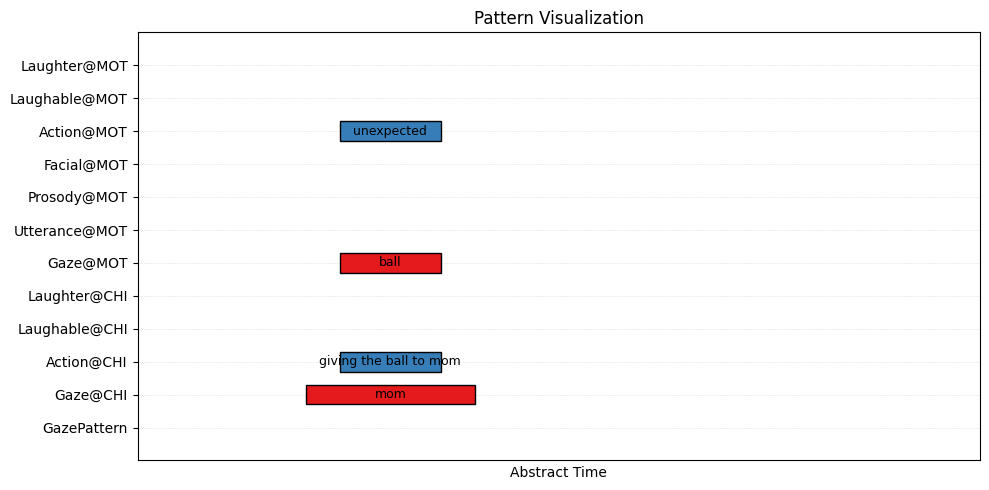

In [ ]:
pattern =  ['Gaze@CHI(mom)-CONTAINS-Action@CHI(giving the ball to mom)',
  'Gaze@CHI(mom)-CONTAINS-Action@MOT(unexpected)',
  'Gaze@CHI(mom)-CONTAINS-Gaze@MOT(ball)',
  3]
plot_single_pattern(pattern)

## Round evolution

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import colorsys
from datetime import datetime

In [ ]:
EVENT_TYPES = [
    "GazePattern",
    "Action",
    "Utterance",
    "Prosody",
    "Facial",
    "Arousal",
    "Laughable",
    "Laughter",
]

cmap = plt.get_cmap("Set1")
BASE_COLORS = {etype: mcolors.to_hex(cmap(i)) for i, etype in enumerate(EVENT_TYPES)}

FIXED_TIERS = [
    "GazePattern",
    # "Gaze@CHI",
    # "Utterance@CHI",
    # "Prosody@CHI",
    "Action@CHI",
    # "Arousal@CHI",
    # "Laughable@CHI",
    "Laughter@CHI",

    # "Gaze@MOT",
    "Utterance@MOT",
    "Prosody@MOT",
    "Facial@MOT",
    "Action@MOT",
    "Laughable@MOT",
    "Laughter@MOT",
]
FIXED_TIERS.reverse()

In [ ]:
def plot_timeline(events, title):
    row_dict = {row: i for i, row in enumerate(FIXED_TIERS)}

    colors = {}
    for tier in FIXED_TIERS:
        event_type = tier.split('@')[0] or tier
        base_color = BASE_COLORS.get(event_type, "#333333")  # fallback
        colors[tier] = mcolors.to_rgb((base_color, 0.8))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, len(FIXED_TIERS) * 0.4))

    for event in events:
        tier = event["Tier_Name"]
        if tier not in row_dict:
            continue
        y = row_dict[tier]
        color = colors[tier]

        # Parse time
        fmt = '%H:%M:%S.%f'
        start_dt = datetime.strptime(event["Start_Time"], fmt)
        end_dt = datetime.strptime(event["End_Time"], fmt)
        start = start_dt.hour * 3600 + start_dt.minute * 60 + start_dt.second + start_dt.microsecond / 1e6
        end = end_dt.hour * 3600 + end_dt.minute * 60 + end_dt.second + end_dt.microsecond / 1e6

        # Handle None values in Annotation_Value
        annotation_value = event["Annotation_Value"] if event["Annotation_Value"] is not None else ""

        # Style for invisible
        if annotation_value.strip().lower() == "invisible":
            face = (*color, 0.15)
            edge = (0, 0, 0, 0)
            label = annotation_value
        else:
            face = color
            edge = (0, 0, 0, 0.2)
            label = annotation_value

        ax.broken_barh([(start, end - start)], (y - 0.2, 0.4),
                       facecolors=face, edgecolor=edge)

        if label:
            ax.text((start + end) / 2, y, label,
                    ha='center', va='center', color='black', fontsize=7)

    ax.set_yticks(list(row_dict.values()))
    ax.set_yticklabels(FIXED_TIERS)
    ax.set_xticklabels([])
    ax.set_xlabel("Time")
    ax.set_title(title)
    ax.grid(False)
    plt.tight_layout()
    plt.show()

In [ ]:
def split_event(e):
    tier, annot = e.split("(", 1)
    if annot.endswith(")"):
        annot = annot[:-1]
    return tier, annot

def take_round_n(df, n, start_event="", start_event_idx=0, end_event=None, end_event_idx=0):
  rounds = df[df['Tier_Name'] == 'Round']
  round = df[df['Tier_Name'] == 'Scene'].iloc[0]

  if n < len(rounds):
      round = rounds.iloc[n]

  if not round.empty:
      round_start = round['Start_Time']
      round_end = round['End_Time']
      df_filtered = pd.DataFrame()

      df_fragment = df[(df['Start_Time']  <= round_end) & (df['End_Time']  >= round_start)].copy()
      df_filtered = pd.concat([df_filtered, df_fragment])
      df = df_filtered.copy()

      preprocessed_df = infer_attention_patterns(df)
      df = preprocessed_df.copy()

      if not start_event and not end_event:
          return df

      tier1, val1 = (None, None) if start_event is None else split_event(start_event)
      tier2, val2 = (None, None) if end_event is None else split_event(end_event)

      # print(tier1, val1)
      # Find the first matching events
      e1 = df[(df['Tier_Name'] == tier1) & (df['Annotation_Value'] == val1)]
      e2 = df[(df['Tier_Name'] == tier2) & (df['Annotation_Value'] == val2)]
      # print(e1,e2)
      if not e1.empty:
          round_start = e1.iloc[start_event_idx]['Start_Time']

      if not e2.empty:
          round_end = e2.iloc[end_event_idx]['End_Time']

      df_final = pd.DataFrame()
      df_fragment = df[(df['Start_Time'] < round_end) & (df['End_Time'] > round_start)].copy()
      df_final = pd.concat([df_final, df_fragment])
      df = df_final.copy()

  else:
      print("Scene tier not found")

  return df

In [ ]:
def preprocessing(sequence_intervals, action_history):
  utterance_mask = sequence_intervals['Tier_Name'].str.startswith("Utterance")
  sequence_intervals.loc[utterance_mask, 'Annotation_Value'] = sequence_intervals.loc[utterance_mask, 'Annotation_Value'].apply(get_utterance_category)
  sequence_intervals = add_temporal_postfixes_to_actions(sequence_intervals, use_postfixes_only=True)
  return sequence_intervals

In [ ]:
def generate_sequences_single_interval(data_df, tiers_to_exclude=[]):
    all_tier_names = data_df['Tier_Name'].unique()
    action_history = {}

    observable_tiers = [name for name in all_tier_names if name not in tiers_to_exclude]
    observable_events_df = data_df[data_df['Tier_Name'].isin(observable_tiers)].copy()

    overlapping_events_list = []
    all_overlapping_events_df = pd.DataFrame()

    round_tier_intervals_df = data_df[data_df['Tier_Name'] == 'Round']
    round_tier_intervals = round_tier_intervals_df[['Start_Time', 'End_Time']].values.tolist()

    all_overlapping_events_df = pd.concat(
        [all_overlapping_events_df, observable_events_df],
        ignore_index=True
    )

    processed_overlapping_events = preprocessing(observable_events_df, action_history)
    overlapping_events_list.append(processed_overlapping_events.to_dict('records'))

    return overlapping_events_list, all_overlapping_events_df

In [ ]:
def get_round_patterns(df, n, start_event=None, start_event_idx=0, end_event=None, end_event_idx=0):
  round = take_round_n(df, n, start_event, start_event_idx, end_event, end_event_idx)
  observable_events_list, all_events_df = generate_sequences_single_interval(round, ["Round", "Scene", "Comment"])
  relation_sequence_single_interval = generate_relation_sequences(observable_events_list, False)
  seq2pat = Seq2Pat(sequences=relation_sequence_single_interval)
  result = seq2pat.get_patterns(min_frequency=1)
  return result, observable_events_list

In [ ]:
round_num = 7
result, observable_events_list = get_round_patterns(
    df, round_num, "Laughter@CHI(L)", 0, "Action@MOT(spitting out the ball)", 0)

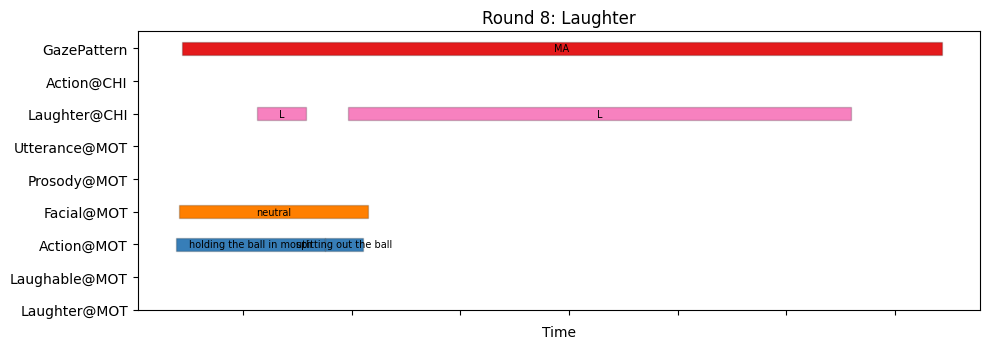

In [ ]:
plot_timeline(observable_events_list[0], f"Round {round_num + 1}: Laughter")

In [ ]:
pattern = [
    item for item in result

    if any(isinstance(subitem, str) and 'Gaze@MOT' in subitem for subitem in item)
    and any(isinstance(subitem, str) and 'Gaze@CHI' in subitem for subitem in item)
    and any(isinstance(subitem, str) and 'Laughter@CHI' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and 'Laughter@MOT' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and 'Facial@MOT' in subitem for subitem in item)

    # and any(isinstance(subitem, str) and 'Action@CHI(giving' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and 'Action@CHI(picking' in subitem for subitem in item)

    and not any(isinstance(subitem, str) and 'GazePattern' in subitem for subitem in item)
    # and any(isinstance(subitem, str) and 'ActionTemporal' in subitem for subitem in item)

    and not any(isinstance(subitem, str) and 'Utterance@CHI' in subitem for subitem in item)
    and not any(isinstance(subitem, str) and 'Prosody@CHI' in subitem for subitem in item)
    and not any(isinstance(subitem, str) and 'Arousal@CHI' in subitem for subitem in item)
    # and not any(isinstance(subitem, str) and 'Laughter@CHI' in subitem for subitem in item)
    # and not any(isinstance(subitem, str) and 'Laughable@CHI' in subitem for subitem in item)
    # and not any(isinstance(subitem, str) and 'Action@CHI' in subitem for subitem in item)
    and not any(isinstance(subitem, str) and 'ReactionReason@CHI' in subitem for subitem in item)
]
len(pattern)

206

In [ ]:
pattern

[['Gaze@CHI(mom)-CONTAINS-Action@MOT(holding the ball in mouth)',
  'Gaze@CHI(mom)-CONTAINS-ActionTemporal@MOT(holding the ball in mouth-FOLLOWS(spitting out the ball))',
  'Gaze@CHI(mom)-CONTAINS-Facial@MOT(neutral)',
  'Gaze@CHI(mom)-CONTAINS-Gaze@MOT(child)',
  'Gaze@CHI(mom)-CONTAINS-Laughter@CHI(L)',
  1],
 ['Gaze@CHI(mom)-CONTAINS-Action@MOT(holding the ball in mouth)',
  'Gaze@CHI(mom)-CONTAINS-ActionTemporal@MOT(holding the ball in mouth-FOLLOWS(spitting out the ball))',
  'Gaze@CHI(mom)-CONTAINS-Facial@MOT(neutral)',
  'Gaze@CHI(mom)-CONTAINS-Gaze@MOT(child)',
  'Gaze@CHI(mom)-CONTAINS-Laughter@CHI(L)',
  'Gaze@CHI(mom)-CONTAINS-Action@MOT(spitting out the ball)',
  1],
 ['Gaze@CHI(mom)-CONTAINS-Action@MOT(holding the ball in mouth)',
  'Gaze@CHI(mom)-CONTAINS-ActionTemporal@MOT(holding the ball in mouth-FOLLOWS(spitting out the ball))',
  'Gaze@CHI(mom)-CONTAINS-Facial@MOT(neutral)',
  'Gaze@CHI(mom)-CONTAINS-Gaze@MOT(child)',
  'Gaze@CHI(mom)-CONTAINS-Laughter@CHI(L)',
  'Ga